# Hex Game - GTM Analysis & Experiments

This notebook performs a comprehensive analysis of the Graph Tsetlin Machine (GTM) on the Hex game.
It implements:
1.  **Robust Data Generation**: Reproducible, seeded games (saved to CSV).
2.  **End-Game Analysis**: Evaluation at Final, End-2, and End-5 moves.
3.  **Parameter Search**: Experiments for Model Capacity (Clauses) and Message Passing (Depth).
4.  **Scaling**: Flexible configuration for 3x3, 11x11, etc.

---

In [85]:
import os
import pickle
import subprocess
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import gc

# Try importing GTM
try:
    from GraphTsetlinMachine.graphs import Graphs
    from GraphTsetlinMachine.tm import MultiClassGraphTsetlinMachine
    HAS_GTM = True
    print("✓ GraphTsetlinMachine detected.")
except ImportError:
    print("WARNING: GraphTsetlinMachine not installed. Training will fail.")
    HAS_GTM = False

# Set Plotting Style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 120

✓ GraphTsetlinMachine detected.


In [86]:
# ==========================================
#            GLOBAL CONFIGURATION
# ==========================================

BOARD_DIM = 7        # 7x7 board
N_GAMES = 30000      # CRITICAL: Need MORE data for 7x7!
SEED = 42

# OPTIMIZED HYPERPARAMETERS FOR 7x7
# These are specifically tuned for the connectivity problem
if BOARD_DIM == 7:
    CLAUSES = 2000           # Much higher capacity needed
    T = 200                  # Very low threshold
    S = 1.2                  # Minimal feature selection
    DEPTH = 8                # Higher depth for connectivity propagation
    EPOCHS = 100             # More epochs
    HYPERVECTOR_SIZE = 512
    MESSAGE_SIZE = 512
    GRID_MULT = 3

elif BOARD_DIM == 3:
    CLAUSES = 200
    T = 400
    S = 2.5
    DEPTH = 3
    EPOCHS = 25
    HYPERVECTOR_SIZE = 256
    MESSAGE_SIZE = 256
    GRID_MULT = 1

else:
    # Fallback
    CLAUSES = 200
    T = 400
    S = 2.5
    DEPTH = 3
    EPOCHS = 25
    HYPERVECTOR_SIZE = 256
    MESSAGE_SIZE = 256
    GRID_MULT = 1

print(f"\n{'='*60}")
print(f"  CONFIGURATION: {BOARD_DIM}x{BOARD_DIM} Hex Board")
print(f"{'='*60}")
print(f"  Games:         {N_GAMES:,}")
print(f"  Clauses:       {CLAUSES:,}")
print(f"  T:             {T}")
print(f"  S:             {S}")
print(f"  Depth:         {DEPTH}")
print(f"  Epochs:        {EPOCHS}")
print(f"  Hypervec Size: {HYPERVECTOR_SIZE}")
print(f"  Message Size:  {MESSAGE_SIZE}")
print(f"{'='*60}\n")

# Paths
RUNS_DIR = "runs"
os.makedirs(RUNS_DIR, exist_ok=True)
CSV_PATH = os.path.join(RUNS_DIR, f"hex_moves_dim{BOARD_DIM}_n{N_GAMES}.csv")


  CONFIGURATION: 7x7 Hex Board
  Games:         30,000
  Clauses:       2,000
  T:             200
  S:             1.2
  Depth:         8
  Epochs:        100
  Hypervec Size: 512
  Message Size:  512



## 1. Data Generation & Processing
We use the C engine to generate games and save them to CSV. This ensures we have a permanent, reproducible dataset.

In [87]:
def generate_data():
    """Generates game data using ./scripts/run_hex.sh"""
    if os.path.exists(CSV_PATH):
        print(f"Found existing data: {CSV_PATH}")
        # You can uncomment the next line to force regeneration
        # os.remove(CSV_PATH)
        return
        
    print(f"Generating {N_GAMES} games for {BOARD_DIM}x{BOARD_DIM} (Seed {SEED})...")
    cmd = [
        "./scripts/run_hex.sh",
        "--games", str(N_GAMES),
        "--seed", str(SEED),
        "--dump-moves", CSV_PATH
    ]
    
    env = os.environ.copy()
    env["BOARD_DIM"] = str(BOARD_DIM)
    
    start = time.time()
    subprocess.run(cmd, env=env, check=True)
    print(f"Done in {time.time() - start:.2f}s")

def load_and_process_data(offset=0):
    """
    Loads CSV and reconstructs board states.
    offset: Number of moves before the end to capture (0=End, 2=End-2, etc.)
    """
    print(f"Processing data with Offset={offset}...")
    df = pd.read_csv(CSV_PATH)
    
    n_nodes = BOARD_DIM * BOARD_DIM
    x_feat = []
    o_feat = []
    labels = []
    
    # Group by game
    for game_id, group in tqdm(df.groupby("game_id"), desc="Replaying Games"):
        # Skip if game is too short
        if len(group) <= offset:
            continue
            
        # Slice moves
        moves = group.iloc[:-offset] if offset > 0 else group
        winner = group["winner"].iloc[0]
        
        p0 = np.zeros(n_nodes, dtype=np.int8)
        p1 = np.zeros(n_nodes, dtype=np.int8)
        
        for _, row in moves.iterrows():
            r, c, p = int(row['row']), int(row['col']), int(row['player'])
            idx = r * BOARD_DIM + c
            if 0 <= idx < n_nodes:
                if p == 0: p0[idx] = 1
                else: p1[idx] = 1
                    
        x_feat.append(p0)
        o_feat.append(p1)
        labels.append(winner)
        
    return np.array(x_feat), np.array(o_feat), np.array(labels)

def prepare_graphs(x, o, init_with=None):
    """Converts Feature Maps -> GTM Graphs using explicit E/X/O symbols"""
    if not HAS_GTM: return None

    n_samples = len(x)
    n_nodes = BOARD_DIM * BOARD_DIM

    # Convert to string representation
    board_strings = []
    for i in range(n_samples):
        board_str = []
        for node in range(n_nodes):
            if x[i][node] == 1:
                board_str.append("X")
            elif o[i][node] == 1:
                board_str.append("O")
            else:
                board_str.append("E")
        board_strings.append(board_str)

    graphs = Graphs(
        n_samples,
        symbols=["E", "X", "O"],  # Explicit order
        hypervector_size=HYPERVECTOR_SIZE,
        hypervector_bits=2,
        init_with=init_with
    )

    # Hex Edges - 6-neighbor topology
    offsets = [(0, 1), (0, -1), (-1, 1), (1, -1), (-1, 0), (1, 0)]
    adjacency = {}
    for r in range(BOARD_DIM):
        for c in range(BOARD_DIM):
            u = r * BOARD_DIM + c
            adjacency[u] = []
            for dr, dc in offsets:
                nr, nc = r + dr, c + dc
                if 0 <= nr < BOARD_DIM and 0 <= nc < BOARD_DIM:
                    adjacency[u].append(nr * BOARD_DIM + nc)

    # Node Config
    for i in range(n_samples):
        graphs.set_number_of_graph_nodes(i, n_nodes)
    graphs.prepare_node_configuration()

    # Edge Config
    for i in range(n_samples):
        for u in range(n_nodes):
            graphs.add_graph_node(i, u, len(adjacency[u]))
    graphs.prepare_edge_configuration()

    # Add Edges (bidirectional)
    for i in range(n_samples):
        for u in range(n_nodes):
            for v in adjacency[u]:
                graphs.add_graph_node_edge(i, u, v, 0)

    # Add Properties using string symbols
    for i in range(n_samples):
        for u in range(n_nodes):
            graphs.add_graph_node_property(i, u, board_strings[i][u])

    graphs.encode()
    return graphs

### Generate Data Now

In [88]:
generate_data()
print("Data Ready!")

Found existing data: runs/hex_moves_dim7_n30000.csv
Data Ready!


## 2. Main Experiment: End, End-2, End-5 Analysis
We train and test the model on three different game states:
1.  **End**: The final position (Easy).
2.  **End-2**: Two moves before the end (Harder).
3.  **End-5**: Five moves before the end (Hardest).

This uses the parameters configured at the top.

In [ ]:
offsets = [0, 2, 5]
results_main = []

if HAS_GTM:
    for off in offsets:
        print(f"\n{'='*60}")
        print(f"  Running OFFSET = {off} ({BOARD_DIM}x{BOARD_DIM})")
        print(f"{'='*60}")

        # 1. Load
        X_raw, O_raw, Y = load_and_process_data(offset=off)

        # 2. Split (80/20)
        split = int(0.8 * len(Y))
        X_train = (X_raw[:split], O_raw[:split])
        Y_train = Y[:split]
        X_test = (X_raw[split:], O_raw[split:])
        Y_test = Y[split:]

        print(f"Train: {len(Y_train):,}, Test: {len(Y_test):,}")
        print(f"Winner 0: {np.sum(Y_train==0):,} ({100*np.mean(Y_train==0):.1f}%)")
        print(f"Winner 1: {np.sum(Y_train==1):,} ({100*np.mean(Y_train==1):.1f}%)")

        # 3. Graphs
        print("\nBuilding Graphs...")
        t0 = time.time()
        g_train = prepare_graphs(X_train[0], X_train[1])
        g_test = prepare_graphs(X_test[0], X_test[1], init_with=g_train)
        print(f"Done in {time.time()-t0:.1f}s")

        # 4. Train
        print(f"\nTraining GTM...")
        tm = MultiClassGraphTsetlinMachine(
            number_of_clauses=CLAUSES,
            T=T,
            s=S,
            depth=DEPTH,
            message_size=MESSAGE_SIZE,  # Use config value
            message_bits=2,
            max_included_literals=min(64, int(32 * GRID_MULT)),  # Scale with board
            grid=(16*13*GRID_MULT, 1, 1),  # Scale grid with complexity
            block=(128, 1, 1)
        )

        history = []
        eval_interval = max(1, EPOCHS // 10)  # Evaluate 10 times total

        t_start = time.time()
        for ep in tqdm(range(EPOCHS), desc=f"Offset {off}"):
            tm.fit(g_train, Y_train, epochs=1, incremental=True)

            # Periodic evaluation (not every epoch - saves time)
            if (ep + 1) % eval_interval == 0 or ep == 0 or ep == EPOCHS-1:
                p_train = tm.predict(g_train)
                acc = accuracy_score(Y_train, p_train)
                history.append((ep+1, acc * 100))
                tqdm.write(f"  Epoch {ep+1:3d}: Train Acc = {acc*100:.1f}%")

        training_time = time.time() - t_start

        # 5. Final Evaluation
        print(f"\nEvaluating...")
        preds = tm.predict(g_test)
        final_acc = accuracy_score(Y_test, preds)
        cm = confusion_matrix(Y_test, preds)

        # Per-class accuracy
        acc0 = accuracy_score(Y_test[Y_test==0], preds[Y_test==0]) if np.sum(Y_test==0) > 0 else 0
        acc1 = accuracy_score(Y_test[Y_test==1], preds[Y_test==1]) if np.sum(Y_test==1) > 0 else 0

        # Metrics
        p0 = precision_score(Y_test, preds, pos_label=0, zero_division=0)
        p1 = precision_score(Y_test, preds, pos_label=1, zero_division=0)

        print(f"\n{'='*60}")
        print(f"  RESULTS - Offset {off}")
        print(f"{'='*60}")
        print(f"Overall Accuracy:  {final_acc*100:.2f}%")
        print(f"Winner 0 Accuracy: {acc0*100:.2f}%")
        print(f"Winner 1 Accuracy: {acc1*100:.2f}%")
        print(f"Class Gap:         {abs(acc0-acc1)*100:.2f}%")
        print(f"Training Time:     {training_time/60:.1f} min")
        print(f"{'='*60}\n")

        results_main.append({
            "offset": off,
            "acc": final_acc * 100,
            "acc0": acc0 * 100,
            "acc1": acc1 * 100,
            "gap": abs(acc0-acc1) * 100,
            "history": history,
            "cm": cm,
            "preds": preds,
            "y_test": Y_test,
            "training_time": training_time
        })

        # Memory cleanup
        del tm, g_train, g_test
        gc.collect()

    # Save results summary
    summary_df = pd.DataFrame([{
        'offset': r['offset'],
        'accuracy': r['acc'],
        'acc_winner0': r['acc0'],
        'acc_winner1': r['acc1'],
        'gap': r['gap'],
        'time_min': r['training_time']/60
    } for r in results_main])

    summary_path = os.path.join(RUNS_DIR, f"main_results_{BOARD_DIM}x{BOARD_DIM}.csv")
    summary_df.to_csv(summary_path, index=False)
    print(f"✓ Results saved to {summary_path}")


  Running OFFSET = 0 (7x7)
Processing data with Offset=0...


Replaying Games: 100%|██████████| 30000/30000 [00:35<00:00, 835.36it/s]


Train: 24,000, Test: 6,000
Winner 0: 13,090 (54.5%)
Winner 1: 10,910 (45.5%)

Building Graphs...


In [56]:
# =========================================================
#       PARAMETER EXPERIMENTS (Scalable)
# =========================================================

# Define experiment ranges based on board size
if BOARD_DIM <= 5:
    # Small boards: test more granular
    CLAUSE_TESTS = [int(CLAUSES * f) for f in [0.5, 1.0, 2.0, 4.0]]
    DEPTH_TESTS = [max(1, DEPTH-2), DEPTH, DEPTH+2, DEPTH+5]
    REDUCED_EPOCHS = max(15, EPOCHS // 2)
elif BOARD_DIM <= 11:
    # Medium boards: test around optimal
    CLAUSE_TESTS = [int(CLAUSES * f) for f in [0.67, 1.0, 1.5, 2.0]]
    DEPTH_TESTS = [max(1, DEPTH-3), DEPTH, DEPTH+3, DEPTH+6]
    REDUCED_EPOCHS = max(20, EPOCHS // 2)
else:
    # Large boards: test fewer configs (time-expensive)
    CLAUSE_TESTS = [int(CLAUSES * f) for f in [0.75, 1.0, 1.5]]
    DEPTH_TESTS = [DEPTH-3, DEPTH, DEPTH+5]
    REDUCED_EPOCHS = max(25, EPOCHS // 2)

print("\n" + "="*60)
print(f"  PARAMETER EXPERIMENTS - {BOARD_DIM}x{BOARD_DIM}")
print("="*60)
print(f"  Clause tests: {CLAUSE_TESTS}")
print(f"  Depth tests:  {DEPTH_TESTS}")
print(f"  Epochs:       {REDUCED_EPOCHS} (reduced for speed)")
print("="*60 + "\n")

# Use offset=0 (final position) for all experiments
if results_main:
    X_raw, O_raw, Y = load_and_process_data(offset=0)
    split = int(0.8 * len(Y))
    X_train = (X_raw[:split], O_raw[:split])
    Y_train = Y[:split]
    X_test = (X_raw[split:], O_raw[split:])
    Y_test = Y[split:]

    print("Building graphs for experiments...")
    g_train = prepare_graphs(X_train[0], X_train[1])
    g_test = prepare_graphs(X_test[0], X_test[1], init_with=g_train)
    print("Done!\n")

    # === EXPERIMENT 1: Model Capacity ===
    print("\n" + "-"*60)
    print("EXPERIMENT 1: Model Capacity (Varying Clauses)")
    print("-"*60 + "\n")

    results_capacity = []

    for c in CLAUSE_TESTS:
        print(f"Testing {c} clauses...")
        t0 = time.time()

        tm = MultiClassGraphTsetlinMachine(
            number_of_clauses=c,
            T=T, s=S, depth=DEPTH,  # Keep depth constant
            message_size=MESSAGE_SIZE,
            message_bits=2,
            max_included_literals=min(64, int(32 * GRID_MULT)),
            grid=(16*13*GRID_MULT, 1, 1),
            block=(128, 1, 1)
        )

        for _ in tqdm(range(REDUCED_EPOCHS), desc=f"  {c} clauses", leave=False):
            tm.fit(g_train, Y_train, epochs=1, incremental=True)

        preds = tm.predict(g_test)
        acc = accuracy_score(Y_test, preds)
        acc0 = accuracy_score(Y_test[Y_test==0], preds[Y_test==0]) if np.sum(Y_test==0) > 0 else 0
        acc1 = accuracy_score(Y_test[Y_test==1], preds[Y_test==1]) if np.sum(Y_test==1) > 0 else 0

        elapsed = time.time() - t0

        results_capacity.append({
            "clauses": c,
            "overall": acc*100,
            "winner0": acc0*100,
            "winner1": acc1*100,
            "gap": abs(acc0-acc1)*100,
            "time_min": elapsed/60
        })

        print(f"  → Overall: {acc*100:.1f}% | W0: {acc0*100:.1f}% | W1: {acc1*100:.1f}% | Time: {elapsed/60:.1f}min\n")

        del tm
        gc.collect()

    # === EXPERIMENT 2: Message Passing Depth ===
    print("\n" + "-"*60)
    print("EXPERIMENT 2: Message Passing Depth")
    print("-"*60 + "\n")

    results_depth = []

    for d in DEPTH_TESTS:
        if d < 1:
            continue  # Skip invalid depths

        print(f"Testing depth {d}...")
        t0 = time.time()

        tm = MultiClassGraphTsetlinMachine(
            number_of_clauses=CLAUSES,  # Keep clauses constant
            T=T, s=S, depth=d,
            message_size=MESSAGE_SIZE,
            message_bits=2,
            max_included_literals=min(64, int(32 * GRID_MULT)),
            grid=(16*13*GRID_MULT, 1, 1),
            block=(128, 1, 1)
        )

        for _ in tqdm(range(REDUCED_EPOCHS), desc=f"  Depth {d}", leave=False):
            tm.fit(g_train, Y_train, epochs=1, incremental=True)

        preds = tm.predict(g_test)
        acc = accuracy_score(Y_test, preds)
        acc0 = accuracy_score(Y_test[Y_test==0], preds[Y_test==0]) if np.sum(Y_test==0) > 0 else 0
        acc1 = accuracy_score(Y_test[Y_test==1], preds[Y_test==1]) if np.sum(Y_test==1) > 0 else 0

        elapsed = time.time() - t0

        results_depth.append({
            "depth": d,
            "overall": acc*100,
            "winner0": acc0*100,
            "winner1": acc1*100,
            "gap": abs(acc0-acc1)*100,
            "time_min": elapsed/60
        })

        print(f"  → Overall: {acc*100:.1f}% | W0: {acc0*100:.1f}% | W1: {acc1*100:.1f}% | Time: {elapsed/60:.1f}min\n")

        del tm
        gc.collect()

    # Save results
    df_cap = pd.DataFrame(results_capacity)
    df_depth = pd.DataFrame(results_depth)

    cap_path = os.path.join(RUNS_DIR, f"capacity_{BOARD_DIM}x{BOARD_DIM}.csv")
    depth_path = os.path.join(RUNS_DIR, f"depth_{BOARD_DIM}x{BOARD_DIM}.csv")

    df_cap.to_csv(cap_path, index=False)
    df_depth.to_csv(depth_path, index=False)

    print(f"\n{'='*60}")
    print(f"✓ Results saved!")
    print(f"  {cap_path}")
    print(f"  {depth_path}")
    print(f"{'='*60}\n")


  PARAMETER EXPERIMENTS - 3x3
  Clause tests: [100, 200, 400, 800]
  Depth tests:  [1, 3, 5, 8]
  Epochs:       15 (reduced for speed)

Processing data with Offset=0...


Replaying Games: 100%|██████████| 5000/5000 [00:01<00:00, 3694.50it/s]


Building graphs for experiments...
Done!


------------------------------------------------------------
EXPERIMENT 1: Model Capacity (Varying Clauses)
------------------------------------------------------------

Testing 100 clauses...
Initialization of sparse structure.


  → Overall: 87.4% | W0: 88.7% | W1: 84.5% | Time: 0.5min

Testing 200 clauses...
Initialization of sparse structure.


  → Overall: 83.5% | W0: 95.6% | W1: 55.8% | Time: 0.5min

Testing 400 clauses...
Initialization of sparse structure.


  → Overall: 74.6% | W0: 98.3% | W1: 20.1% | Time: 0.5min

Testing 800 clauses...
Initialization of sparse structure.


  → Overall: 77.8% | W0: 93.7% | W1: 41.3% | Time: 0.6min


------------------------------------------------------------
EXPERIMENT 2: Message Passing Depth
------------------------------------------------------------

Testing depth 1...
Initialization of sparse structure.


  → Overall: 69.7% | W0: 100.0% | W1: 0.0% | Time: 0.2min

Testing depth 3...
Initialization of sparse structure.


  → Overall: 85.7% | W0: 95.7% | W1: 62.7% | Time: 0.5min

Testing depth 5...
Initialization of sparse structure.


  → Overall: 81.3% | W0: 81.1% | W1: 81.8% | Time: 0.7min

Testing depth 8...
Initialization of sparse structure.


  → Overall: 79.3% | W0: 96.6% | W1: 39.6% | Time: 1.3min


✓ Results saved!
  runs/capacity_3x3.csv
  runs/depth_3x3.csv



## 3. Parameter Search (Capacity & Depth)
Use these experiments to find the best configuration for scaling to 11x11.
This runs on the **Final** board state (Offset 0) by default to save time.

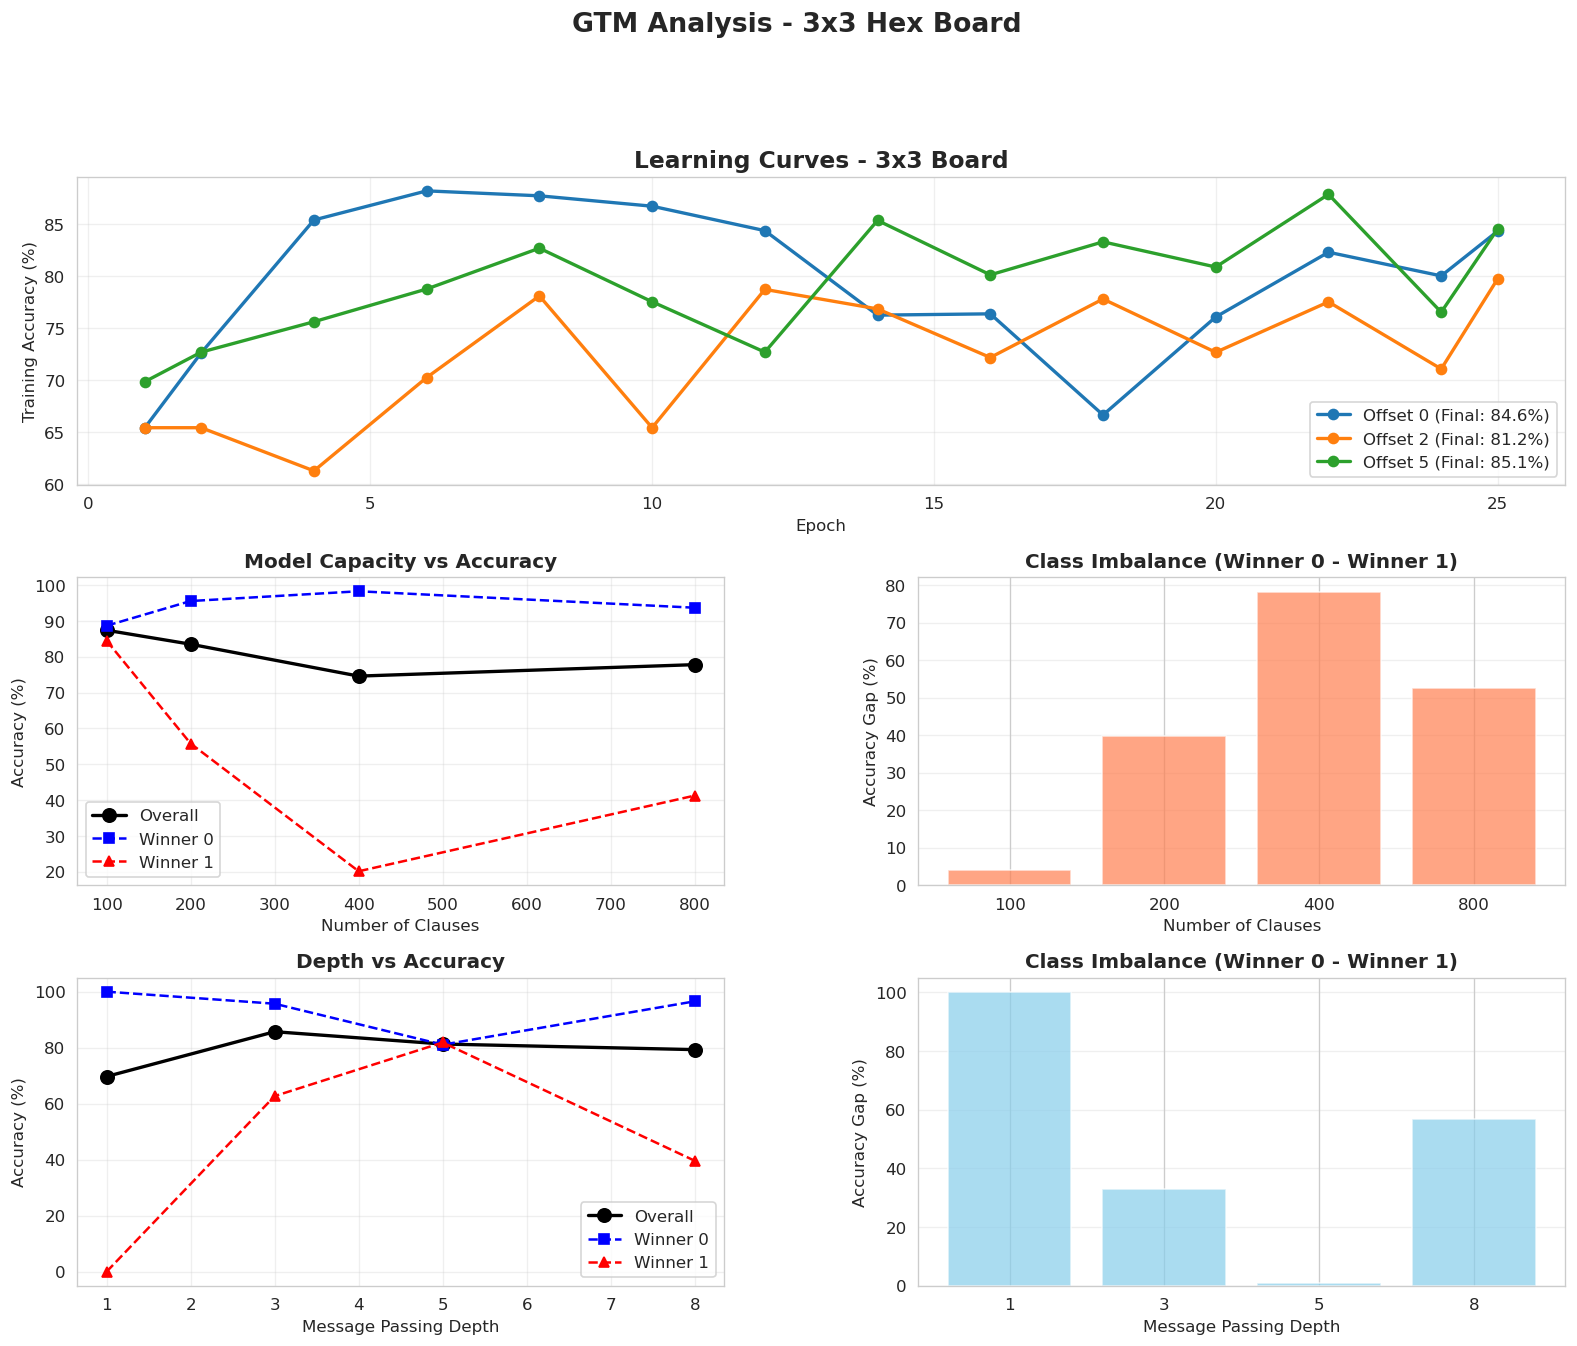


  FINAL SUMMARY - 3x3 Board

CAPACITY EXPERIMENT:
 clauses  overall   winner0   winner1       gap  time_min
     100     87.4 88.665710 84.488449  4.177261  0.526621
     200     83.5 95.552367 55.775578 39.776790  0.489795
     400     74.6 98.278336 20.132013 78.146323  0.537653
     800     77.8 93.687231 41.254125 52.433106  0.600149

DEPTH EXPERIMENT:
 depth  overall    winner0   winner1        gap  time_min
     1     69.7 100.000000  0.000000 100.000000  0.194698
     3     85.7  95.695839 62.706271  32.989569  0.490467
     5     81.3  81.061693 81.848185   0.786492  0.746675
     8     79.3  96.556671 39.603960  56.952711  1.337495

📊 Plot saved: runs/full_analysis_3x3.png



In [57]:
# === COMPREHENSIVE VISUALIZATION ===
if 'results_capacity' in dir() and 'results_depth' in dir():

    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

    df_cap = pd.DataFrame(results_capacity)
    df_depth = pd.DataFrame(results_depth)

    # --- ROW 1: Main Experiment Results ---
    if results_main:
        ax1 = fig.add_subplot(gs[0, :])
        for res in results_main:
            epochs, accs = zip(*res['history'])
            ax1.plot(epochs, accs, 'o-', label=f"Offset {res['offset']} (Final: {res['acc']:.1f}%)", linewidth=2)
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Training Accuracy (%)")
        ax1.set_title(f"Learning Curves - {BOARD_DIM}x{BOARD_DIM} Board", fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

    # --- ROW 2: Capacity Experiment ---
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(df_cap['clauses'], df_cap['overall'], 'o-', color='black', linewidth=2, markersize=8, label='Overall')
    ax2.plot(df_cap['clauses'], df_cap['winner0'], 's--', color='blue', linewidth=1.5, markersize=6, label='Winner 0')
    ax2.plot(df_cap['clauses'], df_cap['winner1'], '^--', color='red', linewidth=1.5, markersize=6, label='Winner 1')
    ax2.set_xlabel("Number of Clauses")
    ax2.set_ylabel("Accuracy (%)")
    ax2.set_title("Model Capacity vs Accuracy", fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax3 = fig.add_subplot(gs[1, 1])
    ax3.bar(df_cap['clauses'].astype(str), df_cap['gap'], color='coral', alpha=0.7)
    ax3.set_xlabel("Number of Clauses")
    ax3.set_ylabel("Accuracy Gap (%)")
    ax3.set_title("Class Imbalance (Winner 0 - Winner 1)", fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    # --- ROW 3: Depth Experiment ---
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.plot(df_depth['depth'], df_depth['overall'], 'o-', color='black', linewidth=2, markersize=8, label='Overall')
    ax4.plot(df_depth['depth'], df_depth['winner0'], 's--', color='blue', linewidth=1.5, markersize=6, label='Winner 0')
    ax4.plot(df_depth['depth'], df_depth['winner1'], '^--', color='red', linewidth=1.5, markersize=6, label='Winner 1')
    ax4.set_xlabel("Message Passing Depth")
    ax4.set_ylabel("Accuracy (%)")
    ax4.set_title("Depth vs Accuracy", fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    ax5 = fig.add_subplot(gs[2, 1])
    ax5.bar(df_depth['depth'].astype(str), df_depth['gap'], color='skyblue', alpha=0.7)
    ax5.set_xlabel("Message Passing Depth")
    ax5.set_ylabel("Accuracy Gap (%)")
    ax5.set_title("Class Imbalance (Winner 0 - Winner 1)", fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')

    plt.suptitle(f"GTM Analysis - {BOARD_DIM}x{BOARD_DIM} Hex Board", fontsize=16, fontweight='bold', y=0.995)

    plot_path = os.path.join(RUNS_DIR, f"full_analysis_{BOARD_DIM}x{BOARD_DIM}.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n{'='*70}")
    print(f"  FINAL SUMMARY - {BOARD_DIM}x{BOARD_DIM} Board")
    print(f"{'='*70}\n")

    print("CAPACITY EXPERIMENT:")
    print(df_cap.to_string(index=False))

    print(f"\n{'='*70}")
    print("DEPTH EXPERIMENT:")
    print(df_depth.to_string(index=False))

    print(f"\n{'='*70}")
    print(f"📊 Plot saved: {plot_path}")
    print(f"{'='*70}\n")